# Binned Jeans analysis tutorial

In this example, we will use JeansGNN to perform a binned Jeans analysis to recover
the dark matter density profile of an example dwarf galaxy.

This implementation is based on the following paper:
- [1] Chang & Necib (2020) https://arxiv.org/abs/2009.00613

In [21]:
%load_ext autoreload
%autoreload 2

import bilby
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric
import yaml

import jeans_gnn as jgnn

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read an example galaxy 
As a first step, we read the 2D position and line-of-sight velocity of the stars in the example galaxy. 

Note that unlike the GNN-based inference in `jgnn.gnn`, the Jeans analysis is more computationally intensive, so we can only fit one galaxy at a time.

In [22]:
# Read the example datasets and pick the first galaxy (though any galaxy will work)
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'vel_error', 'labels'])

# Pick the first galaxy
pos = node_features['pos'][1]
vel = node_features['vel'][1]
vel_error = node_features['vel_error'][1]
data = {'pos': pos, 'vel': vel, 'vel_error': vel_error}
truth_parameters = {
    k: v for k, v in zip(headers['labels_order'], graph_features['labels'][1])}

# Print out the truth parameters and the node features of the first 10 stars
print('True parameters:')
for k, v in truth_parameters.items():
    print(f'{k}: {v}')
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

True parameters:
dm_gamma: 1.0077498109274279
dm_log_r_dm: -0.633612420092535
dm_log_rho_0: 6.866133214871631
stellar_log_r_star: -1.2141546817176612
df_beta_0: 0.12881816386775002
df_log_r_a: -0.9183926283597472
Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]


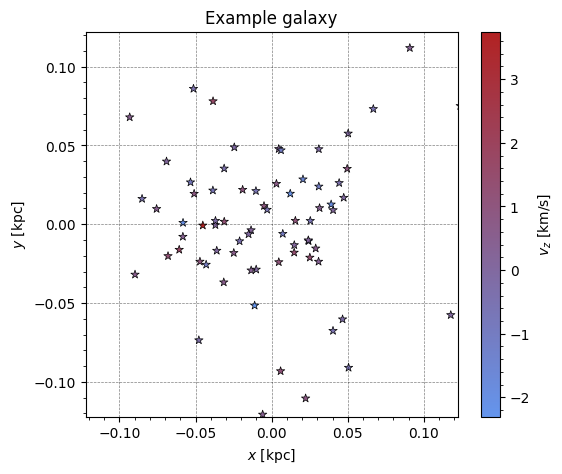

In [23]:
# Plot the example galaxy
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# some plotting parameters
s = 40
marker = '*'
# create a colormap by adding gradients between colors
color1 = 'cornflowerblue'
color2 = 'firebrick'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [color1, color2])
box_size = 2 * 10**truth_parameters['stellar_log_r_star']

# create a log scale for the colorbar
norm = mpl.colors.Normalize(vmin=vel.min(), vmax=vel.max())

# plot the stars
sc = ax.scatter(
    pos[:, 0], pos[:, 1], c=vel, s=s, marker=marker, cmap=cmap,
    norm=norm, edgecolors='k', linewidths=0.5)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.set_title('Example galaxy')
ax.set_xlim(-box_size, box_size)
ax.set_ylim(-box_size, box_size)

# minor ticks and major grid
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.5, linewidth='0.5', color='black')

# colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$v_z$ [km/s]')
cbar.ax.minorticks_on()

plt.show()

## Example 1: Fit the Plummer profile to the light profile

In this example, we will fit the 2D Plummer profile to the light profile of the galaxy. This is a good first step to check if the JeansGNN is working properly.

The 2D Plummer profile has the following form:
$$
I(R) = \frac{L}{\pi a^2} \left[ 1 + \left(\frac{R}{a}\right)^2 \right]^{-2} 
$$
where $L$ is the total luminosity of the galaxy, $a$ is the Plummer scale length, and $R$ is the 2D radius from the center of the galaxy.

In order to fit the Plummer profile with JeansGNN, we will use `jgnn.jeans.binned_lp_model.BinnedLPModel`. We need to specify the following:
- `density`: The light profile of the galaxy, which is a `jgnn.jeans.density_profile.DensityProfile` object. In this example, we will use `jgnn.jeans.density_profile.PlummerProfile` to represent the Plummer profile.
- `data`: The dictionary containing the position of stars. The required key for this example is only `pos`, which is the position of stars. Light profile fit does not require velocity information.
- `priors`: A dictionary containing all the prior distributions in `bilby.core.prior` format.


In [24]:
# Define the bilby priors
priors = bilby.core.prior.PriorDict()
priors["L"] = bilby.core.prior.LogUniform(1e-2, 1e5, "L")
priors["r_star"] = bilby.core.prior.LogUniform(1e-3, 1e3, "r_star")

# Define the light profile model
lp_model = jgnn.jeans.binned_lp_model.BinnedLPModel(
    jgnn.jeans.density_profiles.Plummer, data, priors)

We will run the fit using `bilby` and `dynesty`

In [25]:
# run sampler
lp_model.run_sampler(
    sampler="dynesty", npoints=1000, sample='auto', npool=1, dlogz=0.1,
    label="lp", outdir='example_binned_jeans', resume=False
)

17:23 bilby INFO    : Running for label 'lp', output will be saved to 'example_binned_jeans'
17:23 bilby INFO    : Analysis priors:
17:23 bilby INFO    : L=LogUniform(minimum=0.01, maximum=100000.0, name='L', latex_label='L', unit=None, boundary=None)
17:23 bilby INFO    : r_star=LogUniform(minimum=0.001, maximum=1000.0, name='r_star', latex_label='r_star', unit=None, boundary=None)
17:23 bilby INFO    : Analysis likelihood class: <class 'jeans_gnn.jeans.binned_lp_model.BinnedLPModel'>
17:23 bilby INFO    : Analysis likelihood noise evidence: nan
17:23 bilby INFO    : Single likelihood evaluation took 1.390e-04 s
17:23 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 1000, 'bound': 'live', 'sample': 'auto', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gr

10212it [00:17, 437.89it/s, bound:17 nc:  1 ncall:4.5e+04 eff:22.6% logz=-10.84+/-0.08 dlogz:0.105>0.1]  

17:24 bilby INFO    : Written checkpoint file example_binned_jeans/lp_resume.pickle


10255it [00:25, 405.98it/s, bound:17 nc:  1 ncall:4.6e+04 eff:24.9% logz=-10.74+/-0.08 dlogz:0.000>0.1]

17:24 bilby INFO    : Rejection sampling nested samples to obtain 2769 posterior samples
17:24 bilby INFO    : Sampling time: 0:00:25.257469


17:24 bilby INFO    : Summary of results:
nsamples: 2769
ln_noise_evidence:    nan
ln_evidence: -10.738 +/-  0.106
ln_bayes_factor:    nan +/-  0.106



To examine the posteriors, we first compare the 1D marginalized posteriors of the parameters with the truth values. 

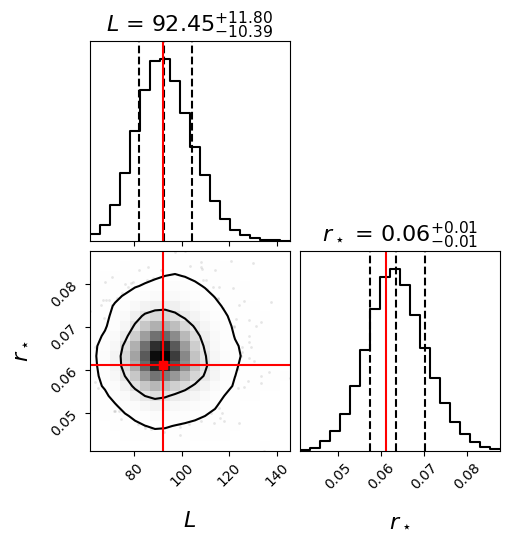

In [26]:
# get posterior samples
samples = lp_model.result.posterior[['L', 'r_star']].to_numpy()

# set truth values, note that L is roughly equal to the number of stars
truths = (len(pos),  10**truth_parameters['stellar_log_r_star'])

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, labels=[r'$L$', r'$r_\star$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)

The posteriors look consistent with the truth parameters!

In the next test, we plot the truth Plummer profile (both analytical and binned) and compare it with the fitted Plummer profile.

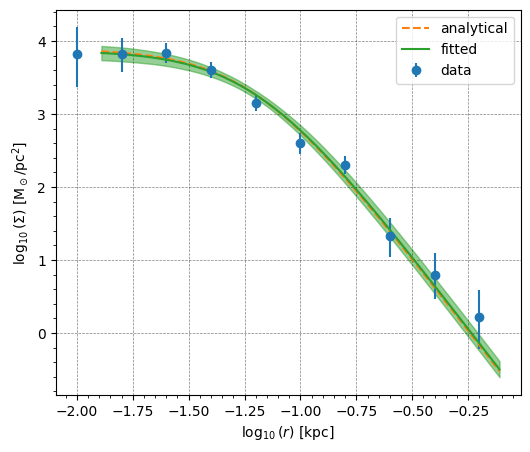

In [7]:
# fitted Plummer model
L_fit = lp_model.result.posterior['L'].to_numpy()
r_star_fit = lp_model.result.posterior['r_star'].to_numpy()
plummer_fit = jgnn.jeans.density_profiles.Plummer(
    L_fit, r_star_fit, projected=True)

# analytical Plummer model
plummer_ana = jgnn.jeans.density_profiles.Plummer(
    L=truths[0], r_star=truths[1], projected=True)

# binned the data
radius = np.linalg.norm(pos, axis=1)
binned_data = jgnn.jeans.utils.calc_Sigma(radius, return_bounds=True)
Sigma, Sigma_lo, Sigma_hi, logR_bins_lo, logR_bins_hi = binned_data

# Plot the light profile logR vs logL
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# plot the binned data as error bars
logR_bins_ce = 0.5 * (logR_bins_lo + logR_bins_hi)
yerr = (np.log10(Sigma) - np.log10(Sigma_lo), np.log10(Sigma_hi) - np.log10(Sigma))
ax.errorbar(logR_bins_ce, np.log10(Sigma), yerr=yerr, fmt='o', label='data')

# plot the fitted and analytical Plummer models
# get min and max radius for plotting
log_r_min = logR_bins_lo.min() * 0.9
log_r_max = logR_bins_hi.max() * 1.1
r = np.logspace(log_r_min, log_r_max, 100)

# plot the analytical Plummer model
ax.plot(np.log10(r), np.log10(plummer_ana(r)), ls='--', label='analytical')

# plot the fitted Plummer model median and 1 sigma range
plummer_fit_q = np.nanpercentile(plummer_fit(r), [16, 50, 84], axis=1)
ax.plot(np.log10(r), np.log10(plummer_fit_q[1]), ls='-', color='C2', label='fitted')
ax.fill_between(
    np.log10(r), np.log10(plummer_fit_q[0]), np.log10(plummer_fit_q[2]),
    alpha=0.5, color='C2')

# set axis labels
ax.set_xlabel(r'$\log_{10}(r)$ [kpc]')
ax.set_ylabel(r'$\log_{10}(\Sigma)$ [M$_\odot$/pc$^2$]')

# minor ticks and major grid
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.5, linewidth='0.5', color='black')

# legend
ax.legend()

plt.show()

Again, we can see that the fitted Plummer profile is consistent with the truth Plummer profile!

## Example 2: Fit the generalized NFW profile using the Jeans equation

In this example, we will fit the generalized NFW profile to the dark matter density profile of the galaxy. This is a good second step to check if the JeansGNN is working properly.

The generalized NFW profile has the following form:
$$
\rho(r) = \rho_0 \left(\frac{r}{r_\mathrm{dm}}\right)^{-\gamma} \left( 1 + \frac{r}{r_\mathrm{dm}} \right)^{-3+\gamma}
$$
where $\rho_0$ is the density normalization, $r_\mathrm{dm}$ is the scale radius, and $\gamma$ is inner slope.

Here, we will use `jgnn.jeans.binned_jeans_model.BinnedJeansModel` to fit the generalized NFW profile. We need to specify the following:
- `dm_profile`: The dark matter density profile of the galaxy, which is a `jgnn.jeans.density_profile.DensityProfile` object. In this example, we will use `jgnn.jeans.density_profile.GeneralizedNFW` to represent the generalized NFW profile.
- `lp_profile`: The light profile of the galaxy, which is a `jgnn.jeans.density_profile.DensityProfile` object. In this example, we will use `jgnn.jeans.density_profile.PlummerProfile` to represent the light profile as a Plummer profile.
- `dist_function`: The distribution function of stars that connects the light profile and the dark matter density profile. In this example, we will use `jgnn.jeans.dist_functions.OsipkovMerritt` to represent the distribution function.
- `data`: The dictionary containing the kinematics of stars. The required keys for Jeans fit are `pos`, `vel`, and `vel_error`, which are for the position, velocity, and velocity error of the stars, respectively.
- `priors`: A dictionary containing all the prior distributions in `bilby.core.prior` format.
  - For simplicity, we will set `L` and `r_star` to the best fit values from the light profile fit. In practice, we should also fit for these parameters.
  - For simplicity, the parameters of the Osipkov-Merritt distribution function are fixed to their truth values. These are `beta_0` and `r_a`, which are the normalization and scale radius of the velocity anisotropy, respectively. In practice, we should also fit for these parameters.

In addition, we set a few additional parameters:
- `dr`: The radial bin size in kpc.
- `fit_v_mean`: Whether to fit for the mean velocity of the stars. If `True`, the mean velocity will be treated as a free parameter. If `False`, the mean velocity will be fixed to the mean of the input velocity.

In [37]:
# Set priors for the Jeans model
priors = bilby.core.prior.PriorDict()
# set gNFW priors
priors["r_dm"] = bilby.core.prior.LogUniform(0.1, 10, "r_dm")
priors["gamma"] = bilby.core.prior.Uniform(-1, 2, "gamma")
priors["rho_0"] = bilby.core.prior.LogUniform(1e5, 1e8, "rho_0")
# set Plummer priors to be fixed at the fitted values
priors["L"] = bilby.core.prior.DeltaFunction(lp_model.get_median('L'), "L")
priors["r_star"] = bilby.core.prior.DeltaFunction(lp_model.get_median('r_star'), "r_star")
# set the prior on the velocity anisotropys to be fixed at the truth
priors['r_a'] = bilby.core.prior.DeltaFunction(10**truth_parameters['df_log_r_a'], 'r_a')
priors['beta_0'] = bilby.core.prior.DeltaFunction(truth_parameters['df_beta_0'], 'beta_0')

dm_model = jgnn.jeans.binned_jeans_model.BinnedJeansModel(
    dm_profile=jgnn.jeans.density_profiles.GeneralizedNFW,
    lp_profile=jgnn.jeans.density_profiles.Plummer,
    dist_function=jgnn.jeans.dist_functions.OsipkovMerritt,
    data=data, priors=priors, fit_v_mean=True, dr=0.01
)

In [38]:
# Run dynesty, increasing the number of processors to 8 to speed up the run
dm_model.run_sampler(
    sampler="dynesty", npoints=1000, sample='auto', npool=8, dlogz=0.1,
    label="dm", outdir='example_binned_jeans', resume=False
)

17:29 bilby INFO    : Running for label 'dm', output will be saved to 'example_binned_jeans'
17:29 bilby INFO    : Analysis priors:
17:29 bilby INFO    : r_dm=LogUniform(minimum=0.1, maximum=10, name='r_dm', latex_label='r_dm', unit=None, boundary=None)
17:29 bilby INFO    : gamma=Uniform(minimum=-1, maximum=2, name='gamma', latex_label='gamma', unit=None, boundary=None)
17:29 bilby INFO    : rho_0=LogUniform(minimum=100000.0, maximum=100000000.0, name='rho_0', latex_label='rho_0', unit=None, boundary=None)
17:29 bilby INFO    : L=92.4545494047297
17:29 bilby INFO    : r_star=0.06336394157200362
17:29 bilby INFO    : r_a=0.12067223921189237
17:29 bilby INFO    : beta_0=0.12881816386775002
17:29 bilby INFO    : v_mean=0.12199206953559837
17:29 bilby INFO    : Analysis likelihood class: <class 'jeans_gnn.jeans.binned_jeans_model.BinnedJeansModel'>
17:29 bilby INFO    : Analysis likelihood noise evidence: nan
17:29 bilby INFO    : Single likelihood evaluation took 7.879e-04 s
17:29 bilby 

7310it [00:49, 361.80it/s, bound:16 nc:  5 ncall:4.6e+04 eff:16.0% logz=-127.39+/-0.06 dlogz:0.101>0.1]

17:30 bilby INFO    : Written checkpoint file example_binned_jeans/dm_resume.pickle
17:30 bilby INFO    : Starting to close worker pool.
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: Resou

7318it [00:55, 132.16it/s, bound:16 nc:  1 ncall:4.7e+04 eff:18.2% logz=-127.31+/-0.06 dlogz:0.000>0.1]

17:30 bilby INFO    : Rejection sampling nested samples to obtain 2734 posterior samples
17:30 bilby INFO    : Sampling time: 0:00:55.285239


17:30 bilby INFO    : Summary of results:
nsamples: 2734
ln_noise_evidence:    nan
ln_evidence: -127.306 +/-  0.078
ln_bayes_factor:    nan +/-  0.078



Because we don't have access to the DM particles, we will only plot the corner plot of the fitted parameters and compare it with the truth values.

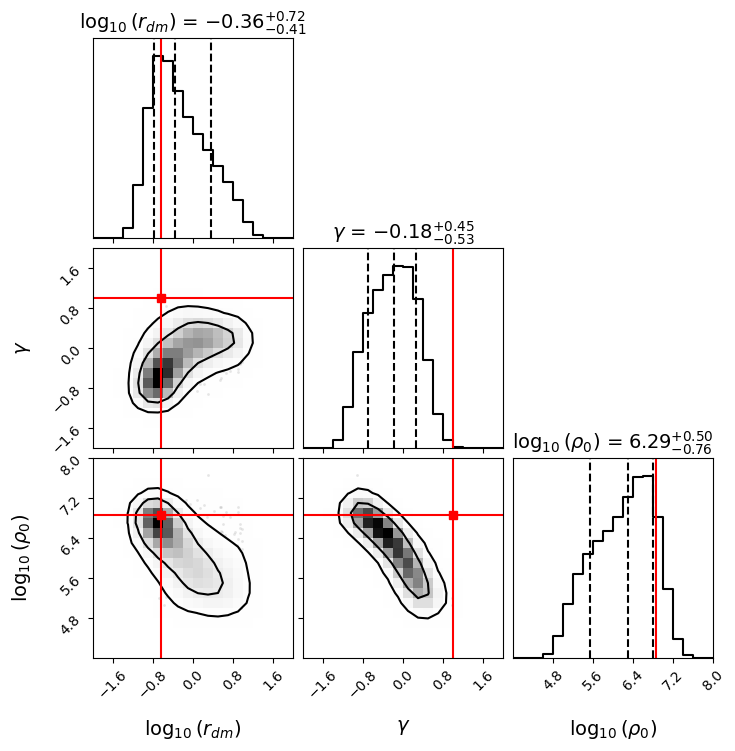

In [40]:
# get posterior samples
samples = dm_model.result.posterior[ ['r_dm', 'gamma', 'rho_0']].to_numpy()
# convert r_dm and rho_0 to log values
samples[:, 0] = np.log10(samples[:, 0])
samples[:, 2] = np.log10(samples[:, 2])

# set truth values, note that L is roughly equal to the number of stars
truths = (
    truth_parameters['dm_log_r_dm'], truth_parameters['dm_gamma'], 
    truth_parameters['dm_log_rho_0'],
)
range = (
    (-2, 2), (-2, 2), (4, 8)
)

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 14}, title_kwargs={'fontsize': 14},
    show_titles=True, labels=[r'$\log_{10}(r_{dm})$', r'$\gamma$', r'$\log_{10}(\rho_0)$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    range=range
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)

We see that the results are not very good, as Chang & Necib (2021) [1] has found. There are significant degeneracies between the parameters, and the fitted parameters are not consistent with the truth values.

## Example 3: Combining everything using JeansGNN wrapper

In this example, we will show how to use JeansGNN InferenceModel to apply the joint DM and light profile fit to a galaxy.
We will use `jgnn.im.jeans_im.JeansInferenceModel` to fit the generalized NFW profile to the dark matter density profile of the galaxy.

An example config file with parameters for the JeansGNN wrapper is provided in `config/jeans_im.yaml`. We will use this config file to run the fit.

In [41]:
# Read config file and print out all information
with open('example_binned_jeans.yaml', 'r') as f:
    config = yaml.safe_load(f)

# print in yaml format
print(yaml.dump(config, sort_keys=False))

method: Jeans
model:
  lp_prior_type: best_median
  jeans_fit:
    fit_v_mean: false
    r_min_factor: 0.5,
    r_max_factor: 2
    dr: 0.1
priors:
  r_dm:
    type: LogUniform
    minimum: 0.1
    maximum: 10
  gamma:
    type: Uniform
    minimum: -1
    maximum: 2
  rho_0:
    type: LogUniform
    minimum: 100000.0
    maximum: 100000000.0
  L:
    type: LogUniform
    minimum: 0.01
    maximum: 100000.0
  r_star:
    type: LogUniform
    minimum: 0.001
    maximum: 1000.0
  r_a:
    type: DeltaFunction
    peak: 0.12067223921189237
  beta_0:
    type: DeltaFunction
    peak: 0.12881816386775002



The prior distribution is defined in `config/jeans_im.yaml`. The prior is parsed automatically by `JeansInferenceModel`.

The JeansInference Model will perform 2 fits:
- A light profile fit using `jgnn.jeans.binned_lp_model.BinnedLPModel`. The priors of the light profile parameters are determined by `config[priors]`.
- A joint DM and light profile fit using `jgnn.jeans.binned_jeans_model.BinnedJeansModel`. The priors of the light profile parameters are determined by the light profile fit using the config `lp_prior_type` option in `config[model]`.

In [42]:
inference_model = jgnn.im.jeans_im.JeansInferenceModel(
    run_name='example_binned_jeans',
    priors=config['priors'],
    model_params=config['model'],
)

# Note that we can also use the config file directly
# The following lines are equivalent to the above
# inference_model = jgnn.im.jeans_im.JeansInferenceModel(
    # run_name='example_binned_jeans',
    # config_file='example_binned_jeans.yaml',
# )

In [43]:
# Call dynesty and return both  the DM and LP models
dm_model, lp_model = inference_model.sample(
    data, sampler='dynesty', sampler_args={
        'npoints': 1000, 'sample': 'auto', 'npool': 8, 'dlogz': 0.1}, 
        return_lp_model=True
)

17:30 bilby INFO    : Running for label 'lp_fit', output will be saved to 'example_binned_jeans/data'
17:30 bilby INFO    : Analysis priors:
17:30 bilby INFO    : L=LogUniform(minimum=0.01, maximum=100000.0, name='L', latex_label='L', unit=None, boundary=None)
17:30 bilby INFO    : r_star=LogUniform(minimum=0.001, maximum=1000.0, name='r_star', latex_label='r_star', unit=None, boundary=None)
17:30 bilby INFO    : Analysis likelihood class: <class 'jeans_gnn.jeans.binned_lp_model.BinnedLPModel'>
17:30 bilby INFO    : Analysis likelihood noise evidence: nan
17:30 bilby INFO    : Single likelihood evaluation took 6.209e-05 s
17:30 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 1000, 'bound': 'live', 'sample': 'auto', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 8, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': 

10403it [00:42, 446.37it/s, bound:17 nc:  1 ncall:4.6e+04 eff:22.8% logz=-10.99+/-0.08 dlogz:0.101>0.1] 

17:31 bilby INFO    : Written checkpoint file example_binned_jeans/data/lp_fit_resume.pickle
17:31 bilby INFO    : Starting to close worker pool.
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:

10408it [00:50, 205.55it/s, bound:17 nc:  1 ncall:4.7e+04 eff:25.0% logz=-10.89+/-0.08 dlogz:0.000>0.1]

17:31 bilby INFO    : Rejection sampling nested samples to obtain 2822 posterior samples
17:31 bilby INFO    : Sampling time: 0:00:50.588672


17:31 bilby INFO    : Summary of results:
nsamples: 2822
ln_noise_evidence:    nan
ln_evidence: -10.890 +/-  0.107
ln_bayes_factor:    nan +/-  0.107

17:31 bilby INFO    : Running for label 'dm_fit', output will be saved to 'example_binned_jeans/data'
17:31 bilby INFO    : Analysis priors:
17:31 bilby INFO    : r_dm=LogUniform(minimum=0.1, maximum=10, name='r_dm', latex_label='r_dm', unit=None, boundary=None)
17:31 bilby INFO    : gamma=Uniform(minimum=-1, maximum=2, name='gamma', latex_label='gamma', unit=None, boundary=None)
17:31 bilby INFO    : rho_0=LogUniform(minimum=100000.0, maximum=100000000.0, name='rho_0', latex_label='rho_0', unit=None, boundary=None)
17:31 bilby INFO    : L=92.85615892705536
17:31 bilby INFO    : r_star=0.06313775725509144
17:31 bilby INFO    : r_a=0.12067223921189237
17:31 bilby INFO    : beta_0=0.12881816386775002
17:31 bilby INFO    : v_mean=0.12199206953559837
17:31 bilby INFO    : Analysis likelihood class: <class 'jeans_gnn.jeans.binned_jeans_model.

7057it [01:09, 214.75it/s, bound:16 nc:  6 ncall:4.5e+04 eff:15.7% logz=-124.83+/-0.06 dlogz:0.101>0.1]

17:33 bilby INFO    : Written checkpoint file example_binned_jeans/data/dm_fit_resume.pickle
17:33 bilby INFO    : Starting to close worker pool.
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7efd641f1580>
  self.pid = os.fork()
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/multiprocessing/popen_fork.py:

7064it [01:16, 92.32it/s, bound:16 nc:  1 ncall:4.6e+04 eff:18.0% logz=-124.75+/-0.06 dlogz:0.000>0.1] 

17:33 bilby INFO    : Rejection sampling nested samples to obtain 2620 posterior samples
17:33 bilby INFO    : Sampling time: 0:01:16.439996


17:33 bilby INFO    : Summary of results:
nsamples: 2620
ln_noise_evidence:    nan
ln_evidence: -124.752 +/-  0.077
ln_bayes_factor:    nan +/-  0.077



Similarly, we want see if the fitted parameters are consistent with the truth values and with the posteriors in Example 1 & 2.

First, we plot the light profile fit results.

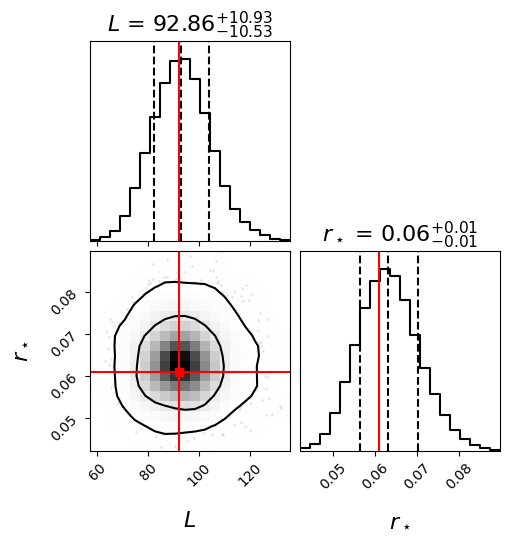

In [45]:
# get posterior samples
samples = lp_model.result.posterior[['L', 'r_star']].to_numpy()

# set truth values, note that L is roughly equal to the number of stars
truths = (len(pos),  10**truth_parameters['stellar_log_r_star'])

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, labels=[r'$L$', r'$r_\star$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)

The light profile is consistent with the truth values! This is not surprising given that `JeansInferenceModel` uses the same light profile fit as in Example 1.

We now examine the DM profile fit results.

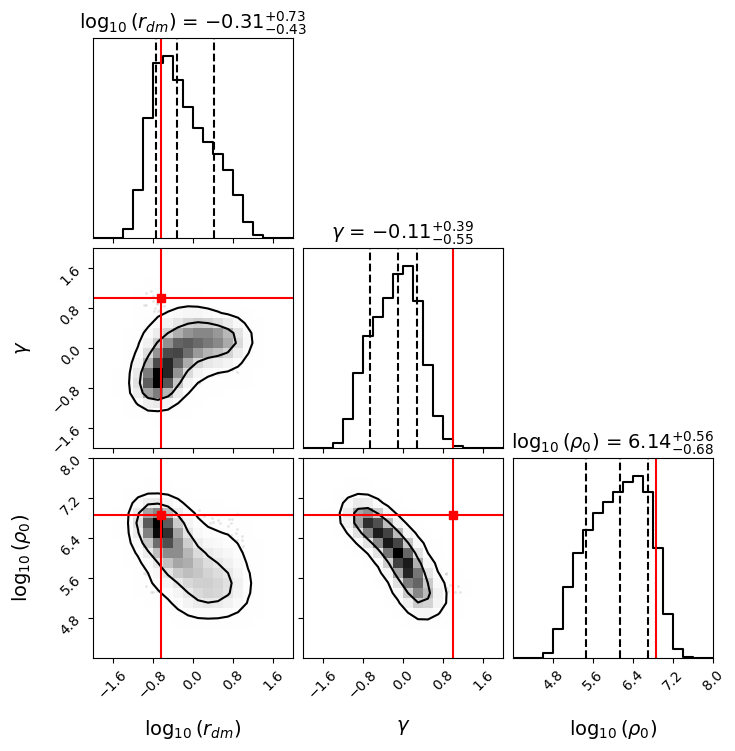

In [46]:
# get posterior samples
samples = dm_model.result.posterior[ ['r_dm', 'gamma', 'rho_0']].to_numpy()
# convert r_dm and rho_0 to log values
samples[:, 0] = np.log10(samples[:, 0])
samples[:, 2] = np.log10(samples[:, 2])

# set truth values, note that L is roughly equal to the number of stars
truths = (
    truth_parameters['dm_log_r_dm'], truth_parameters['dm_gamma'], 
    truth_parameters['dm_log_rho_0'],
)
range = (
    (-2, 2), (-2, 2), (4, 8)
)

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 14}, title_kwargs={'fontsize': 14},
    show_titles=True, labels=[r'$\log_{10}(r_{dm})$', r'$\gamma$', r'$\log_{10}(\rho_0)$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    range=range
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)

The results are consistent with the ones in Example 2. Unfortunately, because `JeansInferenceModel` is just a wrapper for the `BinnedJeansModel`, the results do not improve much.